# Jupiter in Jupyter
### Smoothed Particle Hydrodynamics and Gas Giant Equilibrium 

Sai Chikine & Alex Rybchuk

Advisor: Professor Yecko

Ph 235

# Introduction - SPH


# What is it?

* Particle-based method of solving hydrodynamic equations
* Advantages over grid-based code:
    * No need to deal with extensive grid-refinement
    * Deals well with nearly empty regions (eg: space between galaxies)
    * Better at dealing with problems which lack symmetries

# How does it work?
\begin{equation}
\frac{dv_i}{dt} = -\frac{1}{\rho_i}\nabla P_i - \nabla \Phi_i
\end{equation}

* The crux of SPH lies in this equation
    * The driving question in SPH - how do you calculate density at a point?
    
\begin{equation}
\rho_j(r) = m_j W(|r-r_j|,h)
\end{equation}

# Our Project - Equilibrium of Jupiter

* A gas giant collision is a good candidate for SPH
    * Collisions lack a clear symmetry
* Pressure can be modeled using a simple polytrope relation $P = K\rho^\gamma$

In [57]:
# Imports

%matplotlib inline

from __future__ import division

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist

from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

import numba as nb
import time

In [58]:
# Model constants

RJupiter = 6.99e9                 # radius of Jupiter, cm
mJupiter = 1.898e30               # mass of Jupiter, grams
v = 1e-3                          # damping coefficient
gamma = 2                         # polytrope index
G = 6.67e-8                       # dyne*cm^2/g^2
rhoC = 5                          # g/cm^3, central density
K = 2.6e12*5                        # dyne*cm^4/g^2
h = 2.5e9                         # smoothing length
gravCutoff = 1e8                  # Below this distance, gravity is 0 (to prevent singularities)
#N1 = 50                          # Particles in planet 1

# Position, Velocity, and Mass Intialization

* [Textbook](https://github.com/ribby/Jupiter_SPH/blob/master/NumericalMethodsInAstrophysics.pdf) provides an equation to initialize positions for a normalized coordinate system
* Our implementation didn't provide sensible results, so we went with a Gaussian distribution instead

(250L, 3L)
(500L, 3L)


c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


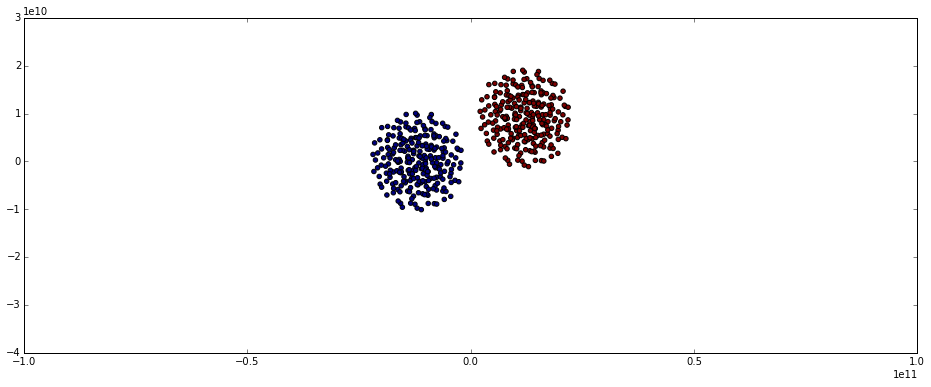

In [59]:
Req = 3e10
Vescape = 5900050
Vinit = Vescape
nParticles = 500

xyzDistribution1 = np.load('3d_equilibrium_position.npy')[-1,:,:]
xyzDistribution1[:,0] += 0.4*Req
xyzDistribution1[:,1] += 0.3*Req
rhoDistribution1 = np.load('3d_equilibrium_density.npy')
planet1 = np.ones_like(rhoDistribution1) * 0.5
velocityDistribution1 = np.zeros((nParticles/2,3), dtype='float') 
velocityDistribution1[:,0] -= Vinit

xyzDistribution2 = np.load('3d_equilibrium_position.npy')[-1,:,:]
xyzDistribution2[:,0] -= 0.4*Req
rhoDistribution2 = np.load('3d_equilibrium_density.npy')
planet2 = np.ones_like(rhoDistribution1) * -0.5
velocityDistribution2 = np.zeros((nParticles/2,3), dtype='float') 
velocityDistribution2[:,0] += Vinit

xyzDistribution = np.concatenate([xyzDistribution1, xyzDistribution2])
rhoDistribution = np.concatenate([rhoDistribution1, rhoDistribution2])
velocityDistribution = np.concatenate([velocityDistribution1, velocityDistribution2])
planetDistribution = np.concatenate([planet1, planet2])
pressureDistribution = K * rhoDistribution ** gamma

mDistribution = 2*np.ones(nParticles)*mJupiter/nParticles

plt.figure(figsize=(16,6))
plt.scatter(xyzDistribution[:,0], xyzDistribution[:,1], c=planetDistribution)
plt.xlim(-1e11,1e11)
plt.ylim(-4e10,3e10)

print xyzDistribution1.shape
print xyzDistribution.shape


# Smoothing Kernel and Density Updates

In [60]:
def W(dist, h):
    '''
    Inputs:
        dist: a scalar distance between particles i an j
        h: smoothing length
    '''
    if dist < h:
        return 1/(np.pi*h**3) * \
               (1/4*(2-dist/h)**3 - (1-dist/h)**3)
    elif dist > 2 * h:
        return 0
    else:
        return 1/(np.pi*h**3) * (1/4*(2-dist/h)**3)

In [61]:
def gradW(xyzDist, h):
    '''
    Inputs:
        xyzDist: a [3,1] array containing the difference in [x,y,z] position
            between two particles
        h: smoothing length
    Outputs:
        a [3,1] array containing the [x,y,z] component of gradW
    '''
    
    dist = np.sqrt(xyzDist[0]**2 + xyzDist[1]**2 + xyzDist[2]**2)
    
    if dist < h:
        return np.array(
                [3*xyzDist[0]*(3*dist - 4*h)/(4*np.pi*h**6),
                 3*xyzDist[1]*(3*dist - 4*h)/(4*np.pi*h**6),
                 3*xyzDist[2]*(3*dist - 4*h)/(4*np.pi*h**6)])
    
    # 2D kernel
#         return np.array(
#               [15*xyDist[0]*(3*dist - 4*h)/(14 * np.pi * h**5),
#                15*xyDist[1]*(3*dist - 4*h)/(14 * np.pi * h**5)])
    
    elif dist > 2 * h:
        return np.array([0,0,0])
    
    else:
        return np.array(
                [-3*xyzDist[0]*(-2*h+dist)**2/(4*h**6*np.pi*dist),
                 -3*xyzDist[1]*(-2*h+dist)**2/(4*h**6*np.pi*dist),
                 -3*xyzDist[2]*(-2*h+dist)**2/(4*h**6*np.pi*dist)])
    
#         return np.array(
#                 [-15*xyDist[0]*(2*h - dist)**2/(14*h**5*np.pi*dist),
#                  -15*xyDist[1]*(2*h - dist)**2/(14*h**5*np.pi*dist)] )

In [62]:
def densityUpdate():
    
    global xyzDistribution
    global rhoDistribution
    global mDistribution

    rhoDistribution = np.zeros_like(rhoDistribution)
    # "Self-density" contribution
    for i in range(0, nParticles):
#        rhoDistribution[i] = mDistribution[i]*W(0, h)
        
        # Density contribution from other particles
        for j in range(i, nParticles):
            xdist = (xyzDistribution[i,0]-xyzDistribution[j,0])
            ydist = (xyzDistribution[i,1]-xyzDistribution[j,1])
            zdist = (xyzDistribution[i,2]-xyzDistribution[j,2])
            dist_ij = np.sqrt(xdist**2 + ydist**2 + zdist**2)
            rho_ij = mDistribution[i]*W(dist_ij, h)
            rhoDistribution[i] += rho_ij
            rhoDistribution[j] += rho_ij

# Pressure Force

In [63]:
def gradP():
    
    gradPArray = np.zeros_like(velocityDistribution)

    for i in range(0, nParticles):
        for j in range(i, nParticles):

            xdist = (xyzDistribution[i,0]-xyzDistribution[j,0])
            ydist = (xyzDistribution[i,1]-xyzDistribution[j,1])
            zdist = (xyzDistribution[i,2]-xyzDistribution[j,2])
            distArr = np.array([xdist,ydist,zdist])

            #gradPX = mDistribution[j]/2*((pressureDistribution[i]/(rhoDistribution[i]**2))+(pressureDistribution[j]/(rhoDistribution[j]**2)))*gradW(distArr,h)[0]
            #gradPY = mDistribution[j]/2*((pressureDistribution[i]/(rhoDistribution[i]**2))+(pressureDistribution[j]/(rhoDistribution[j]**2)))*gradW(distArr,h)[1]
            
#             gradPX = mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[0]
#             gradPY = mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[1]
#             gradPZ = mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[2]
            
            grad = [mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[0], \
                   mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[1],\
                   mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[2]]

            gradPArray[i,:] -= grad
            gradPArray[j,:] += grad
#             gradPArray[i,0] -= gradPX
#             gradPArray[i,1] -= gradPY
#             gradPArray[i,2] -= gradPZ
#             gradPArray[j,0] += gradPX
#             gradPArray[j,1] += gradPY
#             gradPArray[j,2] += gradPZ

    return gradPArray

nb_gradP = nb.autojit(gradP)

# Gravity Force

In [64]:
def gravity(xyDistribution):
    '''
    Returns gravity force matrix. Normally, when 2 particles are close, they exert
    extremely high forces. To combat this, we cutoff gravity at a certain point.
    '''
    global gravCutoff
    
    deltaV = np.zeros_like(xyDistribution, dtype = np.float)
    for i in range(0, nParticles):
        for j in range(0, nParticles):
            if (j!=i):
                xdist = (xyDistribution[i,0]-xyDistribution[j,0])
                ydist = (xyDistribution[i,1]-xyDistribution[j,1])

                if(abs(xdist)<gravCutoff):
                    deltaV[i,0] -= 0
                else:
                    deltaV[i,0] += -G*mDistribution[i]*xdist/((np.sqrt(xdist**2+ydist**2))**3)

                if(abs(ydist)<gravCutoff):
                    deltaV[i,1] -= 0
                else:
                    deltaV[i,1] += -G*mDistribution[i]*ydist/((np.sqrt(xdist**2+ydist**2))**3)
                    
    return deltaV

# Numba gravity - significantly speeds up the function
nb_gravity = nb.autojit(gravity)

# Damping Force

# Density and Pressure Initializaion

In [65]:
# rhoDistribution = np.zeros_like(radiusDistribution)
# densityUpdate()
pressureDistribution = K * rhoDistribution ** gamma

# # Density plot
# plt.figure(figsize=(10,8))
# plt.scatter(radiusDistribution*np.cos(thetaDistribution), \
#             radiusDistribution*np.sin(thetaDistribution), c=rhoDistribution)
# plt.title("Initial Density Distribution of Particles")
# plt.colorbar()
# plt.show()

# # Pressure plot
# plt.figure(figsize=(10,8))
# plt.scatter(radiusDistribution*np.cos(thetaDistribution), \
#             radiusDistribution*np.sin(thetaDistribution), c=pressureDistribution)
# plt.title("Initial Pressure Distribution of Particles")
# plt.colorbar()
# plt.show()

# RK1

In [66]:
# RK1 Parameters
print "Starting at 10:17..."
t0 = time.time()
t = 0
dt = 1e1
stepN = 2000

# Particle history
ParticlePositionHistory = np.zeros((stepN,nParticles,3))
ParticleRhoHistory = np.zeros((stepN, nParticles, 1))
xyzDistributionOld = np.copy(xyzDistribution)

# Force history
forceHistory = np.zeros((stepN, 3))

for i in range(stepN):
    if i % 50 == 0:
        print "Time step", i

    deltaVf = np.zeros_like(xyzDistribution, dtype = np.float)
    
    t += 1
    ParticlePositionHistory[i,:,:] = xyzDistribution
    
    deltaVf += nb_gravity(xyzDistribution) 
#    print "\nAvg gravity", np.mean(deltaVf)
    forceHistory[i,0] = np.mean(abs(deltaVf))

    deltaVf -= -nb_gradP()/rhoDistribution[:,np.newaxis]
#    print "Avg gravity + pressure", np.mean(deltaVf)
    forceHistory[i,1] = np.mean(abs(deltaVf))

    deltaVf +=  -v*velocityDistribution**1
#    print "Avg damping:", np.mean(velocityDistribution)    
    forceHistory[i,2] = np.mean(-v*abs(velocityDistribution**1))

    
    velocityDistribution += dt*deltaVf    
    xyzDistribution += dt*velocityDistribution
    
    densityUpdate()
    ParticleRhoHistory[i,:,:] = rhoDistribution[:,np.newaxis]
    pressureDistribution = K*rhoDistribution**2

print "Total run time:", time.time()-t0


Starting at 10:17...
Time step 0
Time step 50
Time step 100
Time step 150
Time step 200
Time step 250
Time step 300
Time step 350
Time step 400
Time step 450
Time step 500
Time step 550
Time step 600
Time step 650
Time step 700
Time step 750
Time step 800
Time step 850
Time step 900
Time step 950
Time step 1000
Time step 1050
Time step 1100
Time step 1150
Time step 1200
Time step 1250
Time step 1300
Time step 1350
Time step 1400
Time step 1450
Time step 1500
Time step 1550
Time step 1600
Time step 1650
Time step 1700
Time step 1750
Time step 1800
Time step 1850
Time step 1900
Time step 1950
Total run time: 5539.88499999


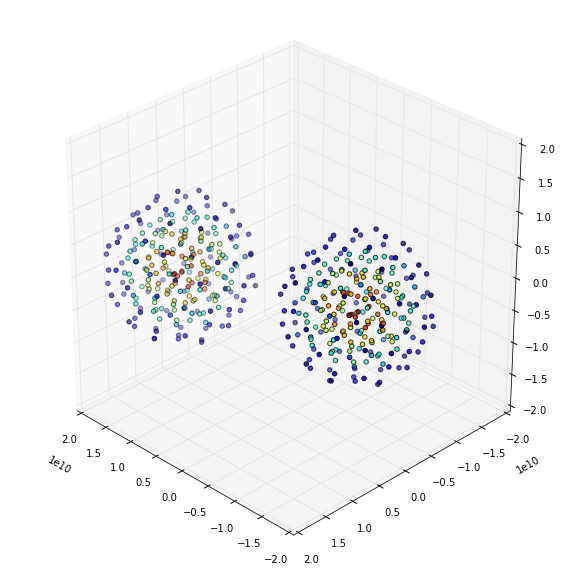

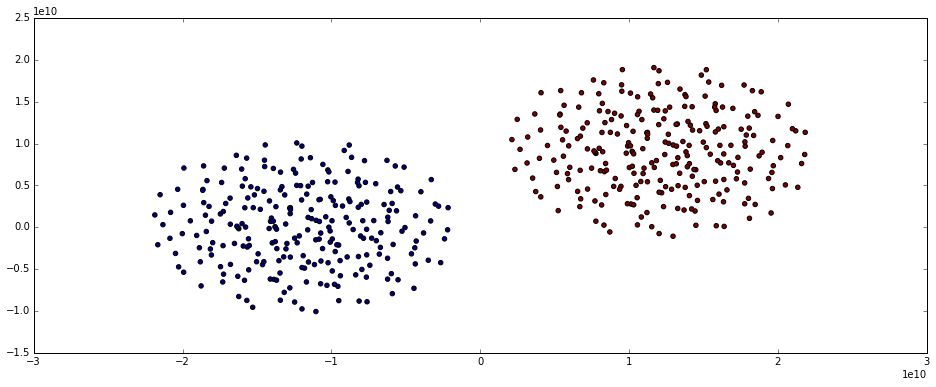

In [67]:
slider = FloatSlider(description='Time', min=1, max=stepN, step=1)

def update_plot():
    time=int(slider.value)
    x = ParticlePositionHistory[time-1,:,0]
    y = ParticlePositionHistory[time-1,:,1]
    z = ParticlePositionHistory[time-1,:,2]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=ParticleRhoHistory[time-1,:,:])
#     fig = plt.figure(figsize=(10,10))
#     plt.scatter(x, y)
    plt.xlim(-2e10,2e10)
    plt.ylim(-2e10,2e10)
    ax.set_zlim(-2e10,2e10)
    ax.azim=135

    plt.figure(figsize=(16,6))
    plt.scatter(x, y, c=planetDistribution)
    clear_output(True)

slider.on_trait_change(update_plot, 'value')


display(slider)
update_plot()

In [68]:
np.save('3d_collision_offaxis_position', ParticlePositionHistory)
np.save('3d_collision_offaxis_density', ParticleRhoHistory)

[]

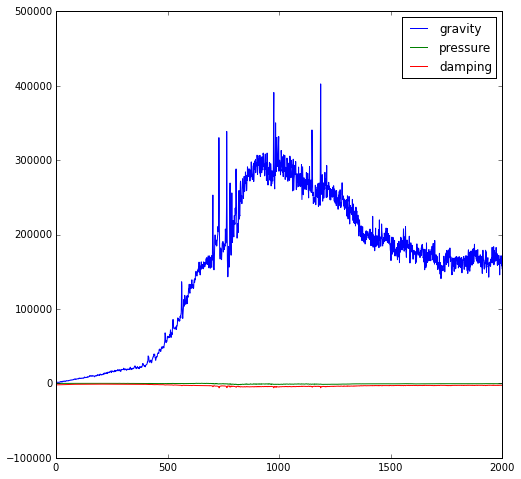

In [69]:
plt.figure(figsize=(8,8))
plt.plot(range(stepN), forceHistory[:,0], label='gravity')
plt.plot(range(stepN), forceHistory[:,1] - forceHistory[:,0], label='pressure')
plt.plot(range(stepN), forceHistory[:,2], label='damping')
#plt.plot(range(stepN), forceHistory[:,1] + forceHistory[:,2], label='net')
#plt.plot(range(stepN), forceHistory[:,1] + forceHistory[:,2], label='net')
plt.legend()
plt.plot()